### Phase 4: Build XGboost machine learning model for traffic flow forecast

In [1]:
# measure execution time
%load_ext autotime

time: 0 ns (started: 2023-07-05 02:49:30 +03:00)


In [2]:
# disable warnings
import warnings
warnings.filterwarnings('ignore')

time: 0 ns (started: 2023-07-05 02:49:30 +03:00)


In [3]:
# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

time: 1.72 s (started: 2023-07-05 02:49:30 +03:00)


### Load the dataset
Measure the traffic flow every 15 minutes for each path.

##### Step 0: Read the dataset

In [4]:
# read dataset
time_series = pd.read_csv('C:/Users/SK/Desktop/Diploma_Thesis/Datasets/San-Francisco-Yellow-Cabs/Files/time_series_per15Minutes.txt')

# print first two rows
time_series.shape

(1000, 676)

time: 156 ms (started: 2023-07-05 02:49:45 +03:00)


In [5]:
# print first rows
time_series.head(3)

,Taxi ID,Traj ID,Path,Length,"(Timestamp('2008-05-18 00:00:00'), Timestamp('2008-05-18 00:15:00'))","(Timestamp('2008-05-18 00:15:00'), Timestamp('2008-05-18 00:30:00'))","(Timestamp('2008-05-18 00:30:00'), Timestamp('2008-05-18 00:45:00'))","(Timestamp('2008-05-18 00:45:00'), Timestamp('2008-05-18 01:00:00'))","(Timestamp('2008-05-18 01:00:00'), Timestamp('2008-05-18 01:15:00'))","(Timestamp('2008-05-18 01:15:00'), Timestamp('2008-05-18 01:30:00'))",...,"(Timestamp('2008-05-24 21:30:00'), Timestamp('2008-05-24 21:45:00'))","(Timestamp('2008-05-24 21:45:00'), Timestamp('2008-05-24 22:00:00'))","(Timestamp('2008-05-24 22:00:00'), Timestamp('2008-05-24 22:15:00'))","(Timestamp('2008-05-24 22:15:00'), Timestamp('2008-05-24 22:30:00'))","(Timestamp('2008-05-24 22:30:00'), Timestamp('2008-05-24 22:45:00'))","(Timestamp('2008-05-24 22:45:00'), Timestamp('2008-05-24 23:00:00'))","(Timestamp('2008-05-24 23:00:00'), Timestamp('2008-05-24 23:15:00'))","(Timestamp('2008-05-24 23:15:00'), Timestamp('2008-05-24 23:30:00'))","(Timestamp('2008-05-24 23:30:00'), Timestamp('2008-05-24 23:45:00'))","(Timestamp('2008-05-24 23:45:00'), Timestamp('2008-05-25 00:00:00'))"
0,157,112,"[254758131, 254758128, 254758128, 27400639]",4,1,0,3,1,0,2,...,2,1,1,2,0,0,1,2,0,1
1,202,148,"[1126161509, 254466686, 254466686, 254466686, ...",15,1,1,0,0,3,2,...,0,1,0,0,0,1,1,0,0,0
2,452,163,"[514412999, 85562484]",2,1,0,2,0,1,0,...,2,0,0,0,0,0,0,0,2,0


time: 16 ms (started: 2023-07-05 02:49:46 +03:00)


##### Step 1: Add new column names

In [6]:
# this list contains the column names
columns = ["Taxi ID","Traj ID","Path","Length"]

# generate the columns of the dataset
i =4
while(True):
    if i == 4:
        columns.append(pd.to_datetime('2008-05-18 00:00:00'))
    else:
        columns.append(columns[i-1] + timedelta(seconds=900))
    
    if (columns[i]>=pd.to_datetime('2008-05-24 23:59:59.000130')):
        break
    
    i+=1

# delete the last timestamp
columns.pop()

# assign new column names to our dataframe
time_series.columns = columns

# print first rows
time_series.head(3)

,Taxi ID,Traj ID,Path,Length,2008-05-18 00:00:00,2008-05-18 00:15:00,2008-05-18 00:30:00,2008-05-18 00:45:00,2008-05-18 01:00:00,2008-05-18 01:15:00,...,2008-05-24 21:30:00,2008-05-24 21:45:00,2008-05-24 22:00:00,2008-05-24 22:15:00,2008-05-24 22:30:00,2008-05-24 22:45:00,2008-05-24 23:00:00,2008-05-24 23:15:00,2008-05-24 23:30:00,2008-05-24 23:45:00
0,157,112,"[254758131, 254758128, 254758128, 27400639]",4,1,0,3,1,0,2,...,2,1,1,2,0,0,1,2,0,1
1,202,148,"[1126161509, 254466686, 254466686, 254466686, ...",15,1,1,0,0,3,2,...,0,1,0,0,0,1,1,0,0,0
2,452,163,"[514412999, 85562484]",2,1,0,2,0,1,0,...,2,0,0,0,0,0,0,0,2,0


time: 156 ms (started: 2023-07-05 02:49:54 +03:00)


### Transform the dataset
#### Step 0: Use the pandas melt function to convert time columns as rows and the rest of them as columns.

In [7]:
# reshape the data from wide format to long format
id_cols = ['Taxi ID','Traj ID', 'Path', 'Length']
time_cols = time_series.iloc[:,2:].columns
time_series = time_series.melt(id_vars=id_cols, value_vars=time_cols, var_name='Time Column', value_name='Traffic Flow')
time_series['Time Column'] = pd.to_datetime(time_series['Time Column'])

# sort rows by Path and Time
time_series.sort_values(by=['Path','Time Column'],inplace=True)

time: 1.05 s (started: 2023-07-05 02:49:57 +03:00)


In [8]:
# print first rows of the dataset
time_series.shape

(672000, 6)

time: 0 ns (started: 2023-07-05 02:49:58 +03:00)


In [9]:
# print first 5 rows
time_series.head(5)

,Taxi ID,Traj ID,Path,Length,Time Column,Traffic Flow
454,279,254,"[100400941, 100400941, 100400941, 100400941, 1...",11,2008-05-18 00:00:00,1
1454,279,254,"[100400941, 100400941, 100400941, 100400941, 1...",11,2008-05-18 00:15:00,3
2454,279,254,"[100400941, 100400941, 100400941, 100400941, 1...",11,2008-05-18 00:30:00,1
3454,279,254,"[100400941, 100400941, 100400941, 100400941, 1...",11,2008-05-18 00:45:00,0
4454,279,254,"[100400941, 100400941, 100400941, 100400941, 1...",11,2008-05-18 01:00:00,2


time: 16 ms (started: 2023-07-05 02:49:58 +03:00)


#### Step 1: Encode the path names to numerical ones for forecast

In [10]:
# convert path column from categorical to numerical
from sklearn.preprocessing import LabelEncoder

# create an instance of LabelEncoder
label_encoder = LabelEncoder()

# fit label encoder on the 'Path' column
time_series['Path'] = label_encoder.fit_transform(time_series['Path'])

# sort the data based in Path column
time_series = time_series.sort_values(by=['Path','Time Column'])

time: 1.78 s (started: 2023-07-05 02:49:58 +03:00)


In [11]:
# print rows
time_series.head()

,Taxi ID,Traj ID,Path,Length,Time Column,Traffic Flow
454,279,254,0,11,2008-05-18 00:00:00,1
1454,279,254,0,11,2008-05-18 00:15:00,3
2454,279,254,0,11,2008-05-18 00:30:00,1
3454,279,254,0,11,2008-05-18 00:45:00,0
4454,279,254,0,11,2008-05-18 01:00:00,2


time: 16 ms (started: 2023-07-05 02:50:00 +03:00)


### Use a function to convert the time series dataset into a supervised problem
Consider for each path n_in timesteps of traffic flow in the past, in order to predict the n_out traffic flow timesteps in the future.

In [12]:
from pandas import DataFrame
from pandas import concat

# create functio for generating (X, y) pairs
def series_to_supervised(data, n_in=1, n_out=1):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('Traffic Flow %d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('Traffic Flow %d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('Traffic Flow %d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    return agg

time: 0 ns (started: 2023-07-05 02:50:00 +03:00)


### Feature Creation From Time Information
We define some features based on time series timestamps.
- Day, dayfweek, hour and minute features derive directly from the timestamp column of the dataset.
- Hour_sin and Hour_cos columns transform the hour values into a cyclic representation, where the values range from -1 to 1. This transformation is used in time series analysis to capture the periodic patterns or cyclical nature of time-related data.
- Use also the 3_hour_interval and 6_hour-interval to describe, in which interval of the day (3-hour or 6-hour) we are.

In [13]:
# extract timestamp information to different columns
time_series['hour'] = time_series['Time Column'].dt.hour
time_series['dayofweek'] = time_series['Time Column'].dt.dayofweek
time_series['day'] = time_series['Time Column'].dt.day
time_series['minute'] = time_series['Time Column'].dt.minute

# circular Encoding for cyclic time features
time_series['hour_sin'] = np.sin(2 * np.pi * time_series['hour'] / 24)
time_series['hour_cos'] = np.cos(2 * np.pi * time_series['hour'] / 24)

time_series['day_of_week_sin'] = np.sin(2 * np.pi * time_series['dayofweek'] / 7)
time_series['day_of_week_cos'] = np.cos(2 * np.pi * time_series['dayofweek'] / 7)

# Convert to cosine and sine values
time_series['day_sin'] = np.sin(2 * np.pi * time_series['day'] / 31)
time_series['day_cos'] = np.cos(2 * np.pi * time_series['day'] / 31)

time_series['minute_sin'] = np.sin(2 * np.pi * time_series['minute'] / 60)
time_series['minute_cos'] = np.cos(2 * np.pi * time_series['minute'] / 60)

time: 547 ms (started: 2023-07-05 02:50:00 +03:00)


In [14]:
# define a custom function to determine the three-hour interval
def get_3hour_interval(hour):
    if hour in [1, 2, 3]:
        return 1
    elif hour in [4, 5, 6]:
        return 2
    elif hour in [7, 8, 9]:
        return 3
    elif hour in [10, 11, 12]:
        return 4
    elif hour in [13, 14, 15]:
        return 5
    elif hour in [16, 17, 18]:
        return 6
    elif hour in [19, 20, 21]:
        return 7
    elif hour in [22, 23, 0]:
        return 8
    else:
        return None   

time: 0 ns (started: 2023-07-05 02:50:00 +03:00)


In [15]:
# apply the custom function to create the '3hour_interval' column
time_series['3hour_interval'] = time_series['hour'].apply(get_3hour_interval)

time: 594 ms (started: 2023-07-05 02:50:00 +03:00)


In [16]:
# define a custom function to determine the 6-hour interval
def get_6hour_interval(hour):
    if hour in [1, 2, 3, 4, 5, 6]:
        return 1
    elif hour in [7, 8, 9, 10, 11, 12]:
        return 2
    elif hour in [13, 14, 15, 16, 17, 18]:
        return 3
    elif hour in [19, 20, 21, 22, 23, 0]:
        return 4
    else:
        return None   

time: 16 ms (started: 2023-07-05 02:50:01 +03:00)


In [17]:
# apply the custom function to create the '6hour_interval' column
time_series['6hour_interval'] = time_series['hour'].apply(get_6hour_interval)

time: 546 ms (started: 2023-07-05 02:50:01 +03:00)


In [18]:
# print first rows
time_series.head()

,Taxi ID,Traj ID,Path,Length,Time Column,Traffic Flow,hour,dayofweek,day,minute,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos,minute_sin,minute_cos,3hour_interval,6hour_interval
454,279,254,0,11,2008-05-18 00:00:00,1,0,6,18,0,0.000000,1.000000,-0.781831,0.62349,-0.485302,-0.874347,0.000000e+00,1.000000e+00,8,4
1454,279,254,0,11,2008-05-18 00:15:00,3,0,6,18,15,0.000000,1.000000,-0.781831,0.62349,-0.485302,-0.874347,1.000000e+00,2.832769e-16,8,4
2454,279,254,0,11,2008-05-18 00:30:00,1,0,6,18,30,0.000000,1.000000,-0.781831,0.62349,-0.485302,-0.874347,5.665539e-16,-1.000000e+00,8,4
3454,279,254,0,11,2008-05-18 00:45:00,0,0,6,18,45,0.000000,1.000000,-0.781831,0.62349,-0.485302,-0.874347,-1.000000e+00,-1.836970e-16,8,4
4454,279,254,0,11,2008-05-18 01:00:00,2,1,6,18,0,0.258819,0.965926,-0.781831,0.62349,-0.485302,-0.874347,0.000000e+00,1.000000e+00,1,1


time: 31 ms (started: 2023-07-05 02:50:01 +03:00)


### Train - Test split
Split the data into two datasets train and test.
The time inteval of all observations in this dataset are within [18-05-2008, 24-05-2008].
- Train dataset contains all the data for each path till 2008-05-23 inclusive.
- The rest of the data (the most resent ones) are in the test dataset

In [19]:
# sort the time series data
time_series.sort_values(by=['Path','Time Column'], inplace=True)

time: 312 ms (started: 2023-07-05 02:50:01 +03:00)


In [20]:
# define train data
train = time_series.loc[time_series['Time Column'] < '2008-05-24']

# define test data
test = time_series.loc[time_series['Time Column'] >= '2008-05-24']

# print the results
print("Train set shape: ",train.shape)
print("Test set shape: ",test.shape)

Train set shape:  (576000, 20)
Test set shape:  (96000, 20)
time: 188 ms (started: 2023-07-05 02:50:02 +03:00)


<Axes: >

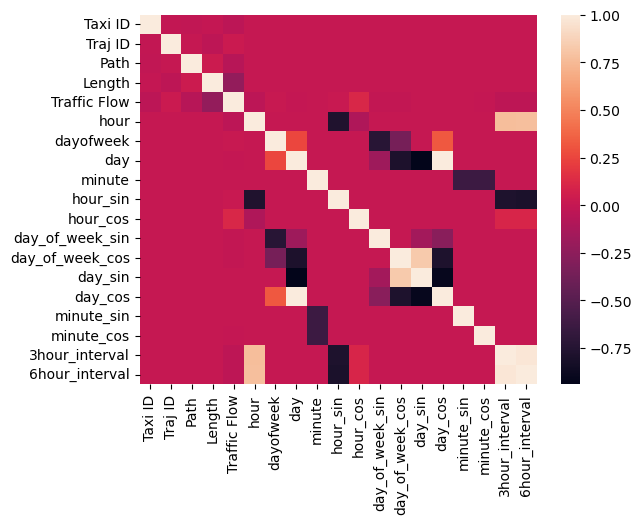

time: 2 s (started: 2023-07-05 02:50:02 +03:00)


In [21]:
import seaborn as sns
sns.heatmap(time_series.corr())

### Find the best lookback timesteps for our XGBoost model

#### Step 0: Create empty dataframe to store the scores per lookback timesteps

In [22]:
# find best lookback timesteps to perform analysis. Save those scores in a separate dataframe
lookback_scores = pd.DataFrame(columns=['#Timesteps','XGBoost Score'])
lookback_scores['#Timesteps'] = 0
lookback_scores['XGBoost Score'] = 0

time: 0 ns (started: 2023-07-05 02:50:04 +03:00)


#### Step 1: Create function that converts the data into a supervised problem

In [23]:
"""
Convert the training data into a supervised dataset. Create X,y pairs of the traffic column information.
Then, concatenate the rest of the culumns. 
"""
def generate_X_y_pairs(data,n_in=1,n_out=1):
    new_data = pd.DataFrame()
    for item in data['Path'].unique():
        
        # call function only for traffic flow columns
        supervised_traffic_flow = series_to_supervised(pd.DataFrame(data[data['Path'] == item]['Traffic Flow']), n_in, n_out)
        
        # the rest of the columns are concatenated as they were
        supervised_traffic_flow = pd.concat([supervised_traffic_flow, time_series[time_series['Path'] == item]], axis=1)
        
        new_data = pd.concat([new_data,supervised_traffic_flow])

    new_data.dropna(inplace=True)
    return new_data

time: 0 ns (started: 2023-07-05 02:50:05 +03:00)


#### Step 2: Create a loop. In each loop, we are doing the following:
- 0. Convert train and test sets into supervised problem with lookback timesteps.
- 1. Define features and labels.
- 2. Train the XGboost model with defult parameters
- 3. Predict on the test set
- 4. Save RMSE in a dataframe

In [24]:
# import libraries
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

time: 141 ms (started: 2023-07-05 02:50:07 +03:00)


In [ ]:
for lookback in [2,3,4,5,6,7,8]: # different lookback sizes
    
    # convert train and test data to supervised
    train_s = generate_X_y_pairs(train,lookback)
    test_s = generate_X_y_pairs(test,lookback)
    
    print("Lookback = "+str(lookback)+" - To supervised: Completed!")

    # add rolling mean information
    train_s['rolling_mean'] = 0
    test_s['rolling_mean'] = 0
    
    train_s['rolling_mean'] = train_s.iloc[:,0:lookback].mean(axis=1)
    test_s['rolling_mean'] = test_s.iloc[:,0:lookback].mean(axis=1)
    
    # define features
    features_s = train_s.drop(['Time Column','Traffic Flow 1(t)'],axis=1).columns
    
    # define label
    labels_s = ['Traffic Flow 1(t)']
    
    # create X_train and y_train datasets
    X_train_s = train_s[features_s]
    y_train_s = train_s[labels_s]
    
    # create X_test and y_test datasets
    X_test_s = test_s[features_s]
    y_test_s = test_s[labels_s]
    
    print("Lookback = "+str(lookback)+" - Train and Test sets: Completed!")

    # define XGBoost regression model
    reg = xgb.XGBRegressor(objective='reg:squarederror',n_estimators=1000,early_stopping_rounds = 5)
    
    # train the XGBoost model with feature weights, use validation set on test data)
    reg.fit(X_train_s, y_train_s, eval_set=[(X_train_s, y_train_s), (X_test_s,y_test_s)],verbose=False)
    
    print("Lookback = "+str(lookback)+" - Trainning: Completed!")
    
    # make predictions
    y_pred_s = reg.predict(X_test_s)
    
    # calculate RMSE score
    rmse = mean_squared_error(y_test_s, y_pred_s, squared=False)
   
    # create a new row as a dictionary
    new_row = {'#Timesteps': lookback, 'XGBoost Score': rmse}

    # append the new row to the DataFrame
    lookback_scores = lookback_scores.append(new_row, ignore_index=True)
    
    print("Lookback = "+str(lookback)+" - Saved Results: Completed!")

####  Step 3: Print RMSE scores over lookback timesteps into a graph

In [ ]:
# plot the data
plt.plot(lookback_scores['#Timesteps'], lookback_scores['XGBoost Score'], linestyle='-', marker='o', color='b')

# set plot title and axis labels
plt.title('Lookback timesteps over RMSE score')
plt.xlabel('Lookback Timesteps of column Traffic Flow')
plt.ylabel('RMSE score after XGBoost testing')

# add gridlines
plt.grid(True)

# show the plot
plt.show()

In [ ]:
# find the timesteps corresponding to the minimum RMSE score
optimum_lookback = int(lookback_scores['#Timesteps'].loc[lookback_scores['XGBoost Score'].idxmin()])

### Perform Grid Search CV to find the optimum parameters for the XGBoost model

#### Step 0: Split train and test into supervised problem, based on optimum lookback timesteps that found above.

In [25]:
# convert train and test data to supervised
train = generate_X_y_pairs(train,optimum_lookback)
test = generate_X_y_pairs(test,optimum_lookback)

time: 1min 34s (started: 2023-07-05 02:50:18 +03:00)


#### Step 1: Extract features about trend of time series
- Rolling mean is a statistical measure that si commonly used in time series analysis and data smoothing. It is calculated over a sliding window or a rolling window, where the window size determines the number of consecutive data points included in the calculation.The rolling mean (or moving average) calculates the average value of a time series within a specific window. It smooths out short-term fluctuations and provides a smoothed representation of the data. The rolling mean at each time point is the average of the values within the window centered around that time point.

In [26]:
# add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

train['rolling_mean'] = train.iloc[:,0:optimum_lookback].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:optimum_lookback].mean(axis=1)

time: 79 ms (started: 2023-07-05 02:51:53 +03:00)


####  Step 2: Define labels and features
- Features will help the XGboost algorithm to predict the putput value, the label. We will use all the traffic flow information at previous timesteps (t-n,t-n+1...,t-2,t-1), as well as the rest of the features (time and trend information) as features.
- Label will be out target value, the Traffic Flow at timestep t.

In [27]:
# define features
features = train.drop(['Time Column','Traffic Flow 1(t)','minute_cos','Traffic Flow','hour', 'dayofweek', 'day', 'minute','6hour_interval'],axis=1).columns

# define labels
labels = ['Traffic Flow 1(t)']

# create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

time: 219 ms (started: 2023-07-05 02:51:53 +03:00)


In [28]:
# show shape information about X and y training and testing sets
print("Shape of X_train is: ",X_train.shape)
print("Shape of y_train is: ",y_train.shape)
print("Shape of X_test is: ",X_test.shape)
print("Shape of y_test is: ",y_test.shape)

Shape of X_train is:  (571000, 18)
Shape of y_train is:  (571000, 1)
Shape of X_test is:  (91000, 18)
Shape of y_test is:  (91000, 1)
time: 0 ns (started: 2023-07-05 02:51:53 +03:00)


#### Step 3: Apply GridSearchCV
Use a 5-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [29]:
from sklearn.model_selection import GridSearchCV

time: 0 ns (started: 2023-07-05 02:51:53 +03:00)


In [ ]:
# tune hyperparameters using XGboost
xgb_params = {
    "n_estimators": [3000],
    "learning_rate": [0.1,0.01],
    "max_depth": [3,6,9],
    "objective":['reg:squarederror'],
    "gamma": [0,1,2],
    "alpha": [0,0.1]
}

# define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(), 
                        xgb_params,cv=3,
                        verbose=1,
                        scoring= "neg_mean_squared_error")

# train on train data using 5 fold CV
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

### Train an XGboost model
We will fit all the data in this model using the optimum parameters that found above. The optimum parameters for this dataset are: 
- n_estimators = 3000
- learning_rate = 0.1
- max_depth = 6
- alpha = 0.5
- gamma = 0.3

#### Step 0: Create XGBoost model and train it

In [30]:
# define XGBoost regressor, use also gamma and alpha values for regularization
reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=3000,
    early_stopping_rounds=5,
    max_depth=5 ,
    learning_rate=0.1,
    gamma=0.3,
    alpha=0.1
    
)

# train the XGBoost model with feature weights, use validation set on test data)
reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test,y_test)], 
        verbose=True)

[0]	validation_0-rmse:3.36967	validation_1-rmse:3.11059
[1]	validation_0-rmse:3.13260	validation_1-rmse:2.89157
[2]	validation_0-rmse:2.92619	validation_1-rmse:2.70143
[3]	validation_0-rmse:2.74731	validation_1-rmse:2.53723
[4]	validation_0-rmse:2.59273	validation_1-rmse:2.39624
[5]	validation_0-rmse:2.46019	validation_1-rmse:2.27574
[6]	validation_0-rmse:2.34703	validation_1-rmse:2.17370
[7]	validation_0-rmse:2.25054	validation_1-rmse:2.08767
[8]	validation_0-rmse:2.16905	validation_1-rmse:2.01509
[9]	validation_0-rmse:2.10039	validation_1-rmse:1.95428
[10]	validation_0-rmse:2.04274	validation_1-rmse:1.90329
[11]	validation_0-rmse:1.99426	validation_1-rmse:1.86132
[12]	validation_0-rmse:1.95392	validation_1-rmse:1.82677
[13]	validation_0-rmse:1.91999	validation_1-rmse:1.79848
[14]	validation_0-rmse:1.89162	validation_1-rmse:1.77541
[15]	validation_0-rmse:1.86788	validation_1-rmse:1.75660
[16]	validation_0-rmse:1.84813	validation_1-rmse:1.74150
[17]	validation_0-rmse:1.83159	validation

XGBRegressor(alpha=0.1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.3, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=3000, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

time: 35.7 s (started: 2023-07-05 02:51:53 +03:00)


##### Feature Importance
Show how our model used the feautres, in order to perform splits. 

<Figure size 1500x500 with 0 Axes>

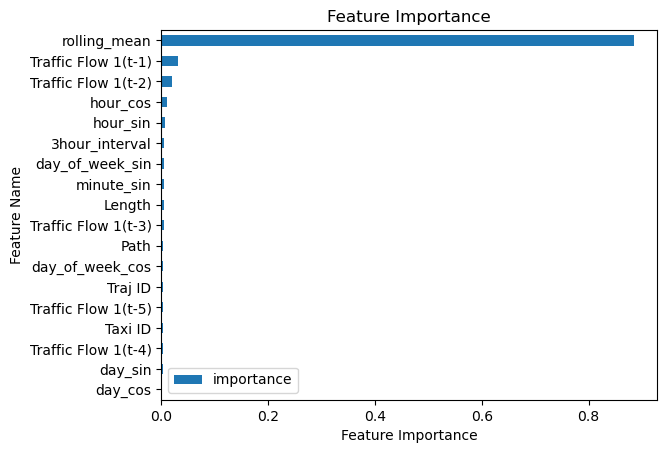

time: 421 ms (started: 2023-07-05 02:52:29 +03:00)


In [31]:
# Show how much each of the features was used in our regression analysis
plt.figure(figsize=(15,5))
fi = pd.DataFrame(data=reg.feature_importances_,index=reg.feature_names_in_,columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.show()

##### Plot train and validation errors in the same graph

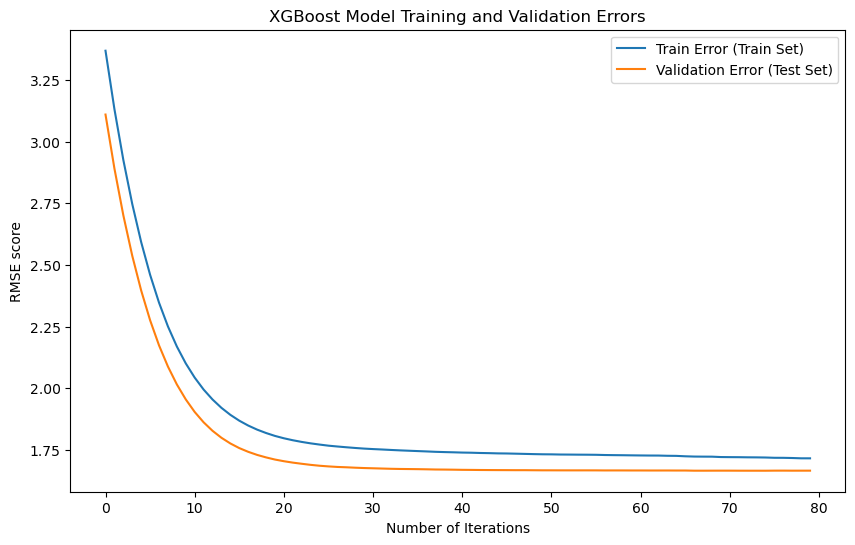

time: 297 ms (started: 2023-07-05 02:52:29 +03:00)


In [32]:
# acquire the values of train and validation errors
results = reg.evals_result()
train_errors = results['validation_0']['rmse']
validation_errors = results['validation_1']['rmse']

# plot the validation and training errors
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train Error (Train Set)')
plt.plot(validation_errors, label='Validation Error (Test Set)')
plt.xlabel('Number of Iterations')
plt.ylabel('RMSE score')
plt.title('XGBoost Model Training and Validation Errors')
plt.legend()
plt.show()

##### Make predictions on the test set

In [33]:
y_pred_xgboost = reg.predict(X_test)

time: 125 ms (started: 2023-07-05 02:52:30 +03:00)


In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate the MAE
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# Calculate RMSE score
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  1.0362124678701325
RMSE score: 1.6647449712660864
time: 15 ms (started: 2023-07-05 02:52:30 +03:00)


##### Show example of how well the model learned the trainning data

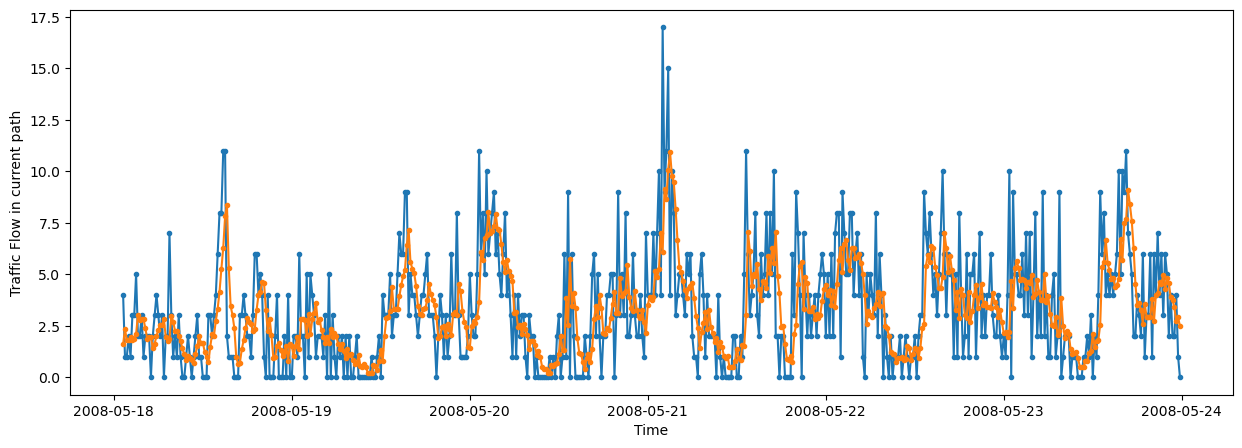

time: 1.11 s (started: 2023-07-05 02:52:30 +03:00)


In [35]:
# predict on the trainning set
y_pred_train = reg.predict(X_train)

# add information in the trainning set
train_predictions = pd.DataFrame(index=pd.to_datetime(train['Time Column']))
train_predictions.insert(0,'Train Actual',y_train['Traffic Flow 1(t)'].values)
train_predictions.insert(1,'Train Predicted',y_pred_train)
train_predictions.insert(2,'Path',X_train['Path'].values)

# plot an example of the train-predictions
plt.figure(figsize=(15,5))
plt.plot(train_predictions[train_predictions['Path']==0][['Train Actual','Train Predicted']],".-")
plt.xlabel('Time')
plt.ylabel('Traffic Flow in current path')
plt.show()

##### Show an example of actual values vs predicted

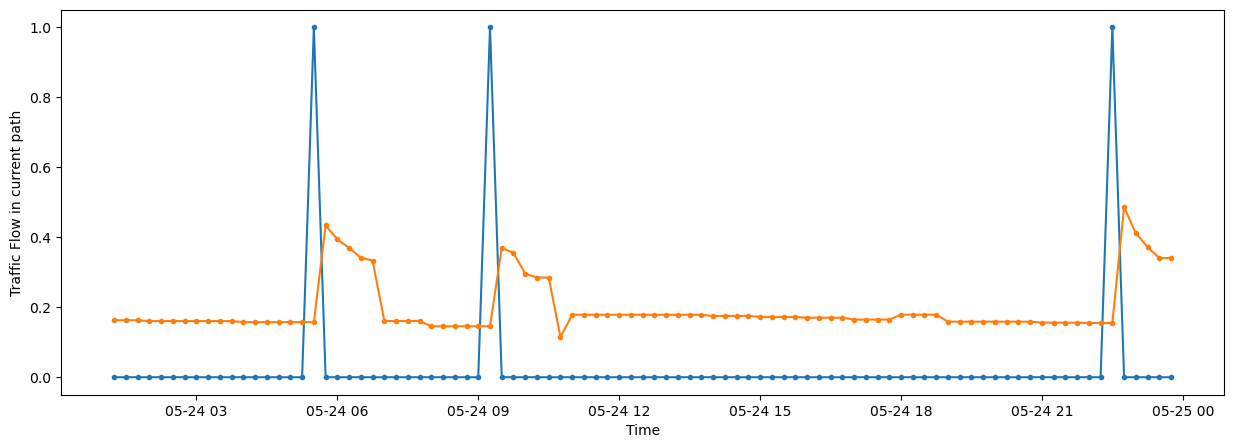

time: 375 ms (started: 2023-07-05 02:52:31 +03:00)


In [36]:
test_predictions = pd.DataFrame(index=pd.to_datetime(test['Time Column']))
test_predictions.insert(0,'Test Actual',y_test['Traffic Flow 1(t)'].values)
test_predictions.insert(1,'Test Predicted',y_pred_xgboost)
test_predictions.insert(2,'Path',X_test['Path'].values)

# plot an example of the train-predictions
plt.figure(figsize=(15,5))
plt.plot(test_predictions[test_predictions['Path']==6][['Test Actual','Test Predicted']],".-")
plt.xlabel('Time')
plt.ylabel('Traffic Flow in current path')
plt.show()

### Train LSTM for time series forecasting

#### Step 0: Create a dataframe to store actual vs predicted values

In [37]:
total_predictions = pd.DataFrame(index=pd.to_datetime(test['Time Column']))
total_predictions['Actual'] = y_test['Traffic Flow 1(t)'].values
total_predictions['Path'] = X_test['Path'].values

time: 31 ms (started: 2023-07-05 02:52:31 +03:00)


#### Step 1: Create the train and test sets as before, then scale them
Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them to the LSTM RNN.

In [38]:
train = train.sort_index()
test = test.sort_index()

time: 297 ms (started: 2023-07-05 02:52:31 +03:00)


In [39]:
from sklearn.preprocessing import MinMaxScaler

time: 0 ns (started: 2023-07-05 02:52:32 +03:00)


In [40]:
# scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

time: 235 ms (started: 2023-07-05 02:52:32 +03:00)


In [41]:
# create train set
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])
    
for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])
    
trainX, trainY = np.array(trainX), np.array(trainY)

time: 1.67 s (started: 2023-07-05 02:52:32 +03:00)


In [42]:
# create test set
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])
    
for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])
    
testX, testY = np.array(testX), np.array(testY)

time: 297 ms (started: 2023-07-05 02:52:33 +03:00)


In [43]:
# print shapes of the created tests
trainX.shape, trainY.shape, testX.shape, testY.shape

((571000, 1, 18), (571000, 1, 1), (91000, 1, 18), (91000, 1, 1))

time: 0 ns (started: 2023-07-05 02:52:34 +03:00)


#### Step 2: Use the LSTM model for forecasting

##### Import libraries and define the LSTM structure

In [44]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import tensorflow as tf

time: 5.23 s (started: 2023-07-05 02:52:34 +03:00)


In [45]:
# Define model
model = Sequential()
model.add(LSTM(60, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))  # Add dropout to the first LSTM layer
model.add(LSTM(30, activation='relu'))
model.add(Dropout(0.2))  # Add dropout to the second LSTM layer
model.add(Dense(trainY.shape[1]))

# Add early stopping
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

time: 469 ms (started: 2023-07-05 02:52:39 +03:00)


##### Compile the model

In [46]:
# compile model
model.compile(optimizer='adam', loss='mse')

time: 16 ms (started: 2023-07-05 02:52:40 +03:00)


##### Train the model

In [47]:
# fit model on training data
model.fit(trainX, trainY, epochs=50, batch_size=5620,validation_data=(testX,testY), verbose=1, callbacks=[early_stopping])

Epoch 1/50
102/102 [==============================] - 13s 94ms/step - loss: 0.0035 - val_loss: 0.0026
Epoch 2/50
102/102 [==============================] - 8s 83ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 3/50
102/102 [==============================] - 9s 86ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 4/50
102/102 [==============================] - 9s 88ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 5/50
102/102 [==============================] - 9s 85ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 6/50
102/102 [==============================] - 9s 90ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 7/50
102/102 [==============================] - 9s 87ms/step - loss: 0.0016 - val_loss: 0.0027


time: 1min 6s (started: 2023-07-05 02:53:00 +03:00)


In [48]:
# evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

2844/2844 [==============================] - 7s 3ms/step - loss: 0.0025
Test Loss: 0.0025258066598325968
time: 7.38 s (started: 2023-07-05 02:54:07 +03:00)


##### Make predictions and store them in dataframe

In [49]:
# predict on test data
y_pred_lstm = model.predict(testX)

2844/2844 [==============================] - 7s 2ms/step
time: 9.53 s (started: 2023-07-05 02:54:14 +03:00)


In [50]:
# calculate the mae of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mean absolute error of LSTM model is: ",mae_lstm)

Mean absolute error of LSTM model is:  1.8338710387561798
time: 0 ns (started: 2023-07-05 02:54:24 +03:00)


### Create Random Forest model

In [ ]:
from sklearn.ensemble import RandomForestRegressor

#### Step 0: Find optimum parameters for random forest

In [ ]:
# define the parameter grid for the grid search
param_grid = {
    'max_depth': [5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4, 8],
}

# create the Random Forest model
rf_model = RandomForestRegressor()

# create the GridSearchCV object
grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='neg_mean_squared_error',verbose=1)

# fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)

# get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# print the best parameters and the best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

In [ ]:
#best_model = RandomForestRegressor(n_estimators=100,max_depth=5,min_samples_split=2,min_samples_leaf=4,verbose=1)
#best_model.fit(X_train,y_train)
#y_pred_rf = best_model.predict(X_test)

#### Step 1: Create and train best model

In [ ]:
# get the best model after Grid Search
best_model = grid_search.best_estimator_

#### Step 2: Make predictions

In [ ]:
# make predictions on the test set
y_pred_rf = best_model.predict(X_test)

#### Step 3: Plot the score of the random forest regressor

In [ ]:
# calculate the MAE
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print("MAE: ", mae_rf)

# calculate the RMSE
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
print("RMSE: ", rmse_rf)

### Add predictions of the three models to the same dataframe

In [51]:
# store predictions of XGBoost model to a dataframe
total_predictions['Predicted XGBoost'] = y_pred_xgboost

time: 15 ms (started: 2023-07-05 02:54:24 +03:00)


In [52]:
# store predictions of LSTM model to a dataframe
total_predictions['Predicted LSTM'] = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

time: 0 ns (started: 2023-07-05 02:54:24 +03:00)


In [ ]:
# add predictions of random forest
total_predictions['Predicted Random Forest'] = y_pred_rf

In [53]:
# print predictions with random forest
total_predictions

,Actual,Path,Predicted XGBoost,Predicted LSTM
Time Column,,,,
2008-05-24 01:15:00,3.0,0,3.652079,2.929721
2008-05-24 01:30:00,2.0,0,3.927778,3.305900
2008-05-24 01:45:00,4.0,0,3.677789,3.317959
2008-05-24 02:00:00,1.0,0,4.080995,3.311590
2008-05-24 02:15:00,5.0,0,3.343788,2.950457
...,...,...,...,...
2008-05-24 22:45:00,1.0,999,1.304105,1.675136
2008-05-24 23:00:00,0.0,999,1.146847,1.441288
2008-05-24 23:15:00,0.0,999,0.808450,1.220439


time: 31 ms (started: 2023-07-05 02:54:24 +03:00)


### Plot examples of actual vs Predicted for each of the models

[]

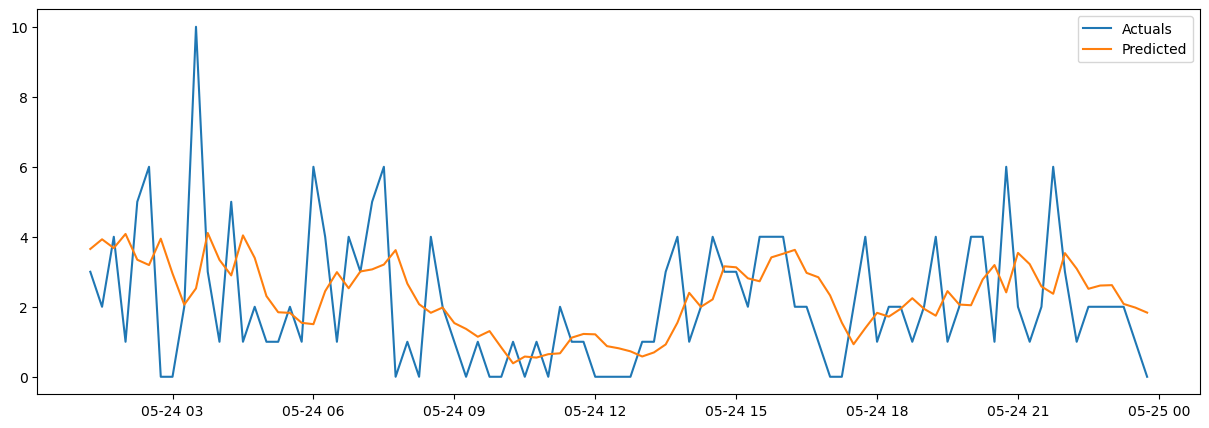

time: 438 ms (started: 2023-07-05 02:54:24 +03:00)


In [54]:
# plot results from XGBoost
plt.figure(figsize=(15,5))
plt.plot(total_predictions[total_predictions['Path']==0]['Actual'],label='Actuals')
plt.plot(total_predictions[total_predictions['Path']==0]['Predicted XGBoost'],label='Predicted')
plt.legend()
plt.plot()

[]

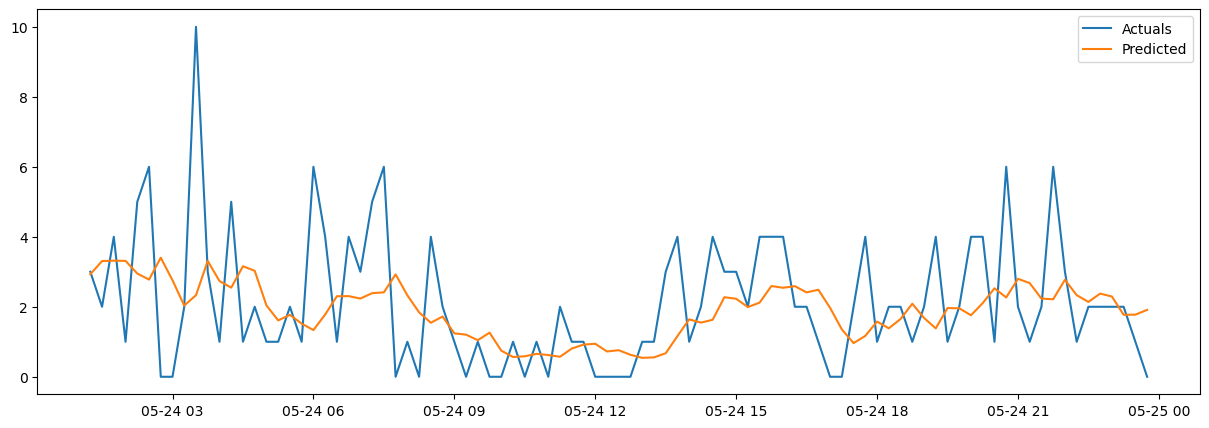

time: 422 ms (started: 2023-07-05 02:54:24 +03:00)


In [55]:
# plot results from LSTM
plt.figure(figsize=(15,5))
plt.plot(total_predictions[total_predictions['Path']==0]['Actual'],label='Actuals')
plt.plot(total_predictions[total_predictions['Path']==0]['Predicted LSTM'],label='Predicted')
plt.legend()
plt.plot()

In [ ]:
# plot results from Random Forest
plt.figure(figsize=(15,5))
plt.plot(total_predictions[total_predictions['Path']==0]['Actual'],label='Actuals')
plt.plot(total_predictions[total_predictions['Path']==0]['Predicted Random Forest'],label='Predicted')
plt.legend()
plt.plot()

In [57]:
from keras.models import Sequential
from keras import layers
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import TimeDistributed
import tensorflow as tf
import pandas as pd

# Assuming you have defined 'trainX', 'trainY', 'testX', 'testY' and 'scaler'

time: 0 ns (started: 2023-07-05 02:55:07 +03:00)


In [58]:
BATCH_SIZE = 1
BUFFER_SIZE = 100

train_univariate = tf.data.Dataset.from_tensor_slices((trainX, trainY))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_univariate = tf.data.Dataset.from_tensor_slices((testX, testY))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

time: 31 ms (started: 2023-07-05 02:55:08 +03:00)


In [59]:
# Add early stopping
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

time: 0 ns (started: 2023-07-05 02:55:09 +03:00)


In [60]:
# Encoder-Decoder Model
# Encoder-Decoder Model
model = Sequential()
model.add(LSTM(256, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse')
history = model.fit(train_univariate, epochs=30, steps_per_epoch=5710,
                    validation_data=val_univariate, validation_steps=910,verbose=1, callbacks=[early_stopping])

Epoch 1/30
5710/5710 [==============================] - 104s 16ms/step - loss: 0.0020 - val_loss: 0.0046
Epoch 2/30
5710/5710 [==============================] - 97s 17ms/step - loss: 0.0021 - val_loss: 0.0044
Epoch 3/30
5710/5710 [==============================] - 122s 21ms/step - loss: 9.7710e-04 - val_loss: 0.0035
Epoch 4/30
5710/5710 [==============================] - 93s 16ms/step - loss: 9.2864e-04 - val_loss: 0.0029
Epoch 5/30
5710/5710 [==============================] - 95s 17ms/step - loss: 7.6100e-04 - val_loss: 0.0039
Epoch 6/30
5710/5710 [==============================] - 93s 16ms/step - loss: 0.0028 - val_loss: 0.0033
Epoch 7/30
5710/5710 [==============================] - 93s 16ms/step - loss: 0.0043 - val_loss: 0.0030
Epoch 8/30
5710/5710 [==============================] - 93s 16ms/step - loss: 5.7470e-04 - val_loss: 0.0027
Epoch 9/30
5710/5710 [==============================] - 95s 17ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 10/30
5710/5710 [=======================

In [61]:
Predicted_results = model.predict(testX)
k = scaler.inverse_transform(Predicted_results.reshape(-1, 1))

2844/2844 [==============================] - 19s 6ms/step
time: 22.5 s (started: 2023-07-05 03:18:44 +03:00)


In [62]:
z = pd.DataFrame(index=pd.to_datetime(test['Time Column']))
z['Actual'] = y_test['Traffic Flow 1(t)'].values  # Assuming testY has shape (410, 1, 1)
z['Transformer Pred'] = k
z['Path'] = test['Path'].values

time: 47 ms (started: 2023-07-05 03:19:07 +03:00)


<Axes: xlabel='Time Column'>

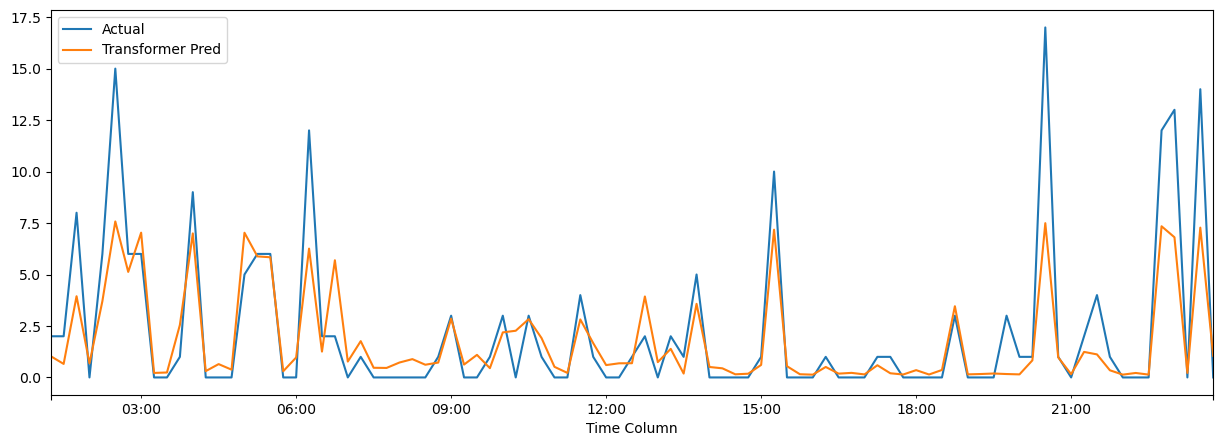

time: 375 ms (started: 2023-07-05 03:20:28 +03:00)


In [71]:
z[z['Path']==32][['Actual','Transformer Pred']].plot(figsize=(15,5))

In [ ]:
z